In [1]:
import os
# os.environ['MUSDB_PATH'] = '/home/ec2-user/proj/data/data/' # '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path

import sys
sys.path.append(os.path.abspath('../'))

In [2]:
import musdb

mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import musdb, museval
import torch
import transforms
import utils
# from mdensenet import MDenseNet
# from mmdensenet import MMDenseNet
from mmdensenet_plus import MMDenseNetPlus
from datasets import SamplingTrackDataset, FullTrackDataset
from tqdm.notebook import tqdm
from augmentation import freq_mask

torch.cuda.device_count()

1

In [4]:
seed = 42

torch.manual_seed(seed)
rng = np.random.default_rng(seed)

train_size, valid_size = 86, 14
sample_length_seconds = 5
sample_length_seconds_valid = 15
batch_size = 8
valid_batch_size = 8

training_data = SamplingTrackDataset(mus_train.tracks[:train_size], seconds=sample_length_seconds, target='bass', rng=rng)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = FullTrackDataset(mus_valid.tracks[:valid_size], seconds=sample_length_seconds_valid, target='bass')
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [5]:
in_channels, num_features = 2, 32

# growth_rate = [12,12,12,12,12,12,12]
growth_rate = [10,10,4,4,10,10,10]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
# depth = [4,4,4,4,4,4,4]
depth = [3,3,3,3,3,3,3]

growth_rate_final=4
kernel_size_final=3
depth_final=2
dilated_final=True
norm_final=True
nonlinear_final=True

model = MMDenseNetPlus(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final, max_bin=2049)
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model)

bottleneck: in 4, growth 4
bottleneck: in 4, growth 4
bottleneck: in 4, growth 4
bottleneck: in 4, growth 4


Layer (type:depth-idx)                                                           Param #
MMDenseNetPlus                                                                   --
├─BandSplit: 1-1                                                                 --
├─ModuleDict: 1-2                                                                --
│    └─MDenseNetBackbone: 2-1                                                    --
│    │    └─Conv2d: 3-1                                                          608
│    │    └─Encoder: 3-2                                                         18,596
│    │    └─TransformerEncoderBottleneck: 3-3                                    396,928
│    │    └─Decoder: 3-4                                                         22,392
│    └─MDenseNetBackbone: 2-2                                                    --
│    │    └─Conv2d: 3-5                                                          608
│    │    └─Encoder: 3-6                                

In [6]:
def step(optimizer, train_loss, model, input, target):
    optimizer.zero_grad()
    # magnitude, phase = torch.abs(mixture), torch.angle(mixture)
    # outputs = model(magnitude) * torch.exp(1j * phase)
    outputs = model(torch.abs(input))

    loss = loss_fn(outputs, torch.abs(target))
    loss.backward()
    optimizer.step()
    
    train_loss.append(loss.item())


In [7]:
epochs = 150
train_losses, valid_losses = [], []

for epoch in tqdm(range(epochs)):

    model.train()
    train_loss = []
    for i, (mixture, target) in enumerate(train_loader):

        step(optimizer, train_loss, model, mixture, target)
    
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (mixture, target) in enumerate(valid_loader):

                outputs = model(torch.abs(mixture))

                loss = loss_fn(outputs, torch.abs(target))
                valid_loss.append(loss.item())

        valid_loss = np.mean(valid_loss)
        valid_losses.append(valid_loss)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')
    else:
        print(f'epoch {epoch}: train loss {train_loss:3f}')

    if (epoch + 1) % 10 == 0:
        model_path = os.path.join('../../models/mmdensenet_transformer_bass', f'trained_model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_path)
        

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 0: train loss 6.097429 valid loss 4.916066
epoch 1: train loss 4.975372
epoch 2: train loss 4.778364
epoch 3: train loss 3.908626
epoch 4: train loss 3.735686
epoch 5: train loss 4.098425
epoch 6: train loss 3.785549
epoch 7: train loss 2.863923
epoch 8: train loss 2.955213
epoch 9: train loss 2.916298 valid loss 2.713303
epoch 10: train loss 2.702515
epoch 11: train loss 2.709564
epoch 12: train loss 2.896679
epoch 13: train loss 2.658048
epoch 14: train loss 2.764607
epoch 15: train loss 2.424505
epoch 16: train loss 2.506681
epoch 17: train loss 2.472142
epoch 18: train loss 2.206964
epoch 19: train loss 2.246257 valid loss 2.086146
epoch 20: train loss 2.352646
epoch 21: train loss 1.619477
epoch 22: train loss 1.746869
epoch 23: train loss 1.644944
epoch 24: train loss 1.701489
epoch 25: train loss 1.839208
epoch 26: train loss 1.796084
epoch 27: train loss 1.643405
epoch 28: train loss 1.578324
epoch 29: train loss 1.579654 valid loss 1.914610
epoch 30: train loss 1.633164


In [8]:
model_path = os.path.join('../../models/mmdensenet_transformer_bass', f'trained_model_epoch_{epochs}.pt')
torch.save(model.cpu().state_dict(), model_path)
torch.save(model.get_config(), os.path.join('../../models/mmdensenet_transformer_bass', f'model_config.pt'))
print(f'Done, model saved at {model_path}')

Done, model saved at ../../models/mmdensenet_transformer_bass/trained_model_epoch_150.pt


In [12]:
model = MMDenseNetPlus.build_model('../../models/mmdensenet_transformer_bass/model_config.pt')
model.load_state_dict(torch.load('../../models/mmdensenet_transformer_bass/trained_model_epoch_140.pt'))

bottleneck: in 4, growth 4
bottleneck: in 4, growth 4
bottleneck: in 4, growth 4
bottleneck: in 4, growth 4


<All keys matched successfully>

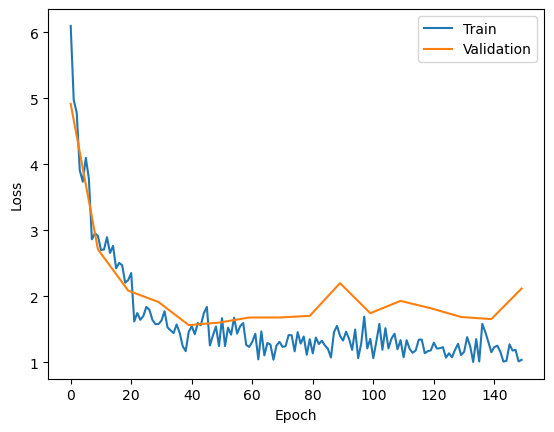

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot([0,9,19,29,39,49,59,69,79,89,99,109,119,129,139,149], valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [13]:
model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i, track in tqdm(enumerate(mus_valid.tracks)):
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 120., sample_targets='bass'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr)

print("validation results")
print("mean:", np.mean(sdrs))
print("median:", np.median(sdrs))
print("std:", np.std(sdrs))

0it [00:00, ?it/s]

0 ANiMAL - Rockshow
5.620451593677927
1 Actions - One Minute Smile
-1.7673192428315336
2 Alexander Ross - Goodbye Bolero
-2.362615010838804
3 Clara Berry And Wooldog - Waltz For My Victims
4.850361809228928
4 Fergessen - Nos Palpitants
-0.6909669084885529
5 James May - On The Line
-1.7377508324782256
6 Johnny Lokke - Promises & Lies
-1.005058532480931
7 Leaf - Summerghost
9.047830522786631
8 Meaxic - Take A Step
4.695089407049843
9 Patrick Talbot - A Reason To Leave
2.941886587013923
10 Skelpolu - Human Mistakes
5.202660940501484
11 Traffic Experiment - Sirens
-3.629905504660473
12 Triviul - Angelsaint
5.45951580602542
13 Young Griffo - Pennies
7.187211809927141
validation results
mean: 2.4150994603166267
median: 3.818487997031883
std: 3.9725698114654806


In [14]:
mus_test = musdb.DB(subsets="test")

model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i in tqdm(range(len(mus_test.tracks))):
        track = mus_test.tracks[i]
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 180., sample_targets='bass'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr[0][0])

print("test results")
print("mean:", np.mean(sdrs))
print("median:", np.median(sdrs))
print("std:", np.std(sdrs))

  0%|          | 0/50 [00:00<?, ?it/s]

0 AM Contra - Heart Peripheral
-3.9291303041771326
1 Al James - Schoolboy Facination
4.913568351734893
2 Angels In Amplifiers - I'm Alright
2.467920430738551
3 Arise - Run Run Run
3.121433770099343
4 BKS - Bulldozer
3.278042392053026
5 BKS - Too Much
6.106773144805881
6 Ben Carrigan - We'll Talk About It All Tonight
4.0485748229465806
7 Bobby Nobody - Stitch Up
2.8843738927234113
8 Buitraker - Revo X
2.8403783422894286
9 Carlos Gonzalez - A Place For Us
-3.3453241643320952
10 Cristina Vane - So Easy
0.39248916864506567
11 Detsky Sad - Walkie Talkie
-4.340211290063138
12 Enda Reilly - Cur An Long Ag Seol
1.1159973265962884
13 Forkupines - Semantics
1.0414947975806872
14 Georgia Wonder - Siren
5.034672333860547
15 Girls Under Glass - We Feel Alright
0.5249055060581929
16 Hollow Ground - Ill Fate
-4.49312238117432
17 James Elder & Mark M Thompson - The English Actor
2.513633074496683
18 Juliet's Rescue - Heartbeats
-1.4329255480145293
19 Little Chicago's Finest - My Own
2.5676908460628614

In [7]:
Kh, Kw = 3, 3
Ph, Pw = Kh - 1, Kw - 1
padding_top = Ph // 2
padding_bottom = Ph - padding_top
padding_left = Pw // 2
padding_right = Pw - padding_left

# for i, f in enumerate(['low', 'middle', 'high', 'full']):
#     print(f)
#     input = torch.rand(1,2,2049,506); print(input.shape)
#     if f != 'full':
#         input = model.bandsplit(input)[i]; 
#     input = nn.functional.pad(input, (padding_left, padding_right, padding_top, padding_bottom)); 
#     x = model.net[f].conv2d(input); print(x.shape)
#     for net in model.net[f].encoder.net:
#         x, skip = net(x); print(x.shape)
#     x = model.net[f].bottleneck_conv2d(x); print(x.shape)
#     # x = model.net[f].decoder(x, skip[::-1]); print(x.shape)

input = torch.rand(1,2,2049,506); print(input.shape)
input = nn.functional.pad(input, (padding_left, padding_right, padding_top, padding_bottom)); 
x = model.net.conv2d(input); print(x.shape)
# for net in model.net.encoder.net:
#     x, skip = net(x); print(x.shape)
x, skip = model.net.encoder(x); print(x.shape)
x = model.net.bottleneck(x); print(x.shape)

torch.Size([1, 2, 2049, 506])
torch.Size([1, 32, 2049, 506])
torch.Size([1, 4, 257, 64])
torch.Size([1, 4, 257, 64])
